In [1]:
import numpy as np
import scipy
import os, sys
import matplotlib.pyplot as plt

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
import basis
import utils
import likelihood
import intensity

%matplotlib inline

## Setup datacube

In [2]:
nx, ny = 30, 30
pix_scale = 1 # arcsec / pixel
true_pars, pars = likelihood.setup_test_pars(nx, ny)
pars['pix_scale'] = pix_scale

li, le, dl = 655.8, 656.8, 0.1
lambdas = [(l, l+dl) for l in np.arange(li, le, dl)]

nspec = len(lambdas)
shape = (nx, ny, nspec)

datacube, sed, true_vmap, true_im = likelihood.setup_likelihood_test(
    true_pars, pars, shape, lambdas
)

## Setup shapelet basis imap

In [144]:
nmax = 12
kwargs = {
    'Nmax': nmax,
    'pix_scale': pix_scale,
    'plane': 'disk',
    'beta': 2.7
}
imap = intensity.BasisIntensityMap(datacube, basis_type='shapelets', basis_kwargs=kwargs)

In [145]:
fit = imap.render(true_pars, datacube, pars)

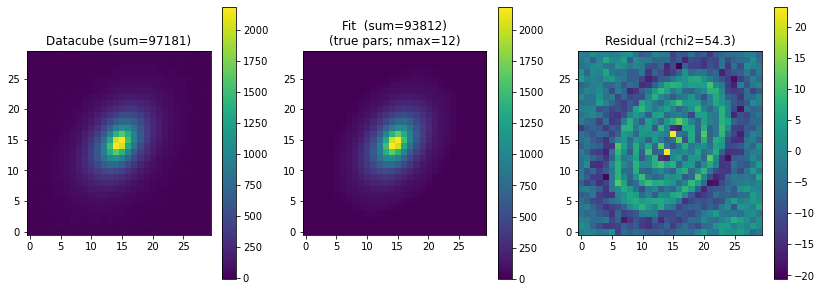

In [146]:
stack = datacube.stack()

fig, axes = plt.subplots(nrows=1,ncols=3,facecolor='w')

plt.subplot(131)
plt.imshow(stack, origin='lower')
plt.colorbar()
s = np.sum(stack)
plt.title(f'Datacube (sum={s:.0f})')

plt.subplot(132)
plt.imshow(fit, origin='lower')
plt.colorbar()
s = np.sum(fit)
plt.title(f'Fit  (sum={s:.0f})\n(true pars; nmax={nmax})')

plt.subplot(133)
plt.imshow(fit-stack, origin='lower')
plt.colorbar()
chi2 = np.sum((fit-stack)**2) / (nx*ny)
plt.title(f'Residual (rchi2={chi2:.1f})')

plt.gcf().set_size_inches(14, 5)

In [150]:
import galsim as gs
am = gs.hsm.FindAdaptiveMom(gs.Image(datacube.stack(), scale=pars['pix_scale']))
print(am)
print(am.moments_sigma)

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=30, ymin=1, ymax=30), moments_status=0, observed_shape=galsim.Shear((-0.06772649969211397+0.18076081979934125j)), moments_sigma=2.7022037506103516, moments_amp=79665.953125, moments_centroid=galsim.PositionD(x=15.501211020213383, y=15.500567946446546), moments_rho4=2.333268305156636, moments_n_iter=31, correction_status=-10)
2.7022037506103516


### Check that the coefficient -> basis func mapping makes sense

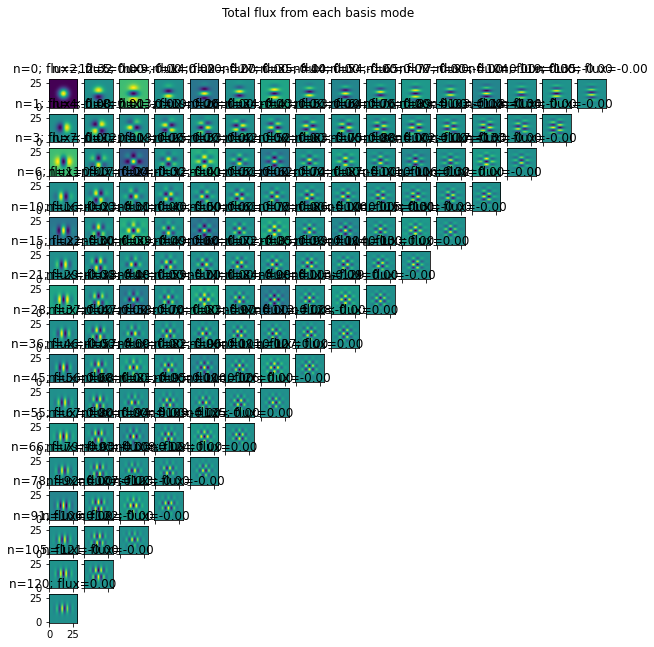

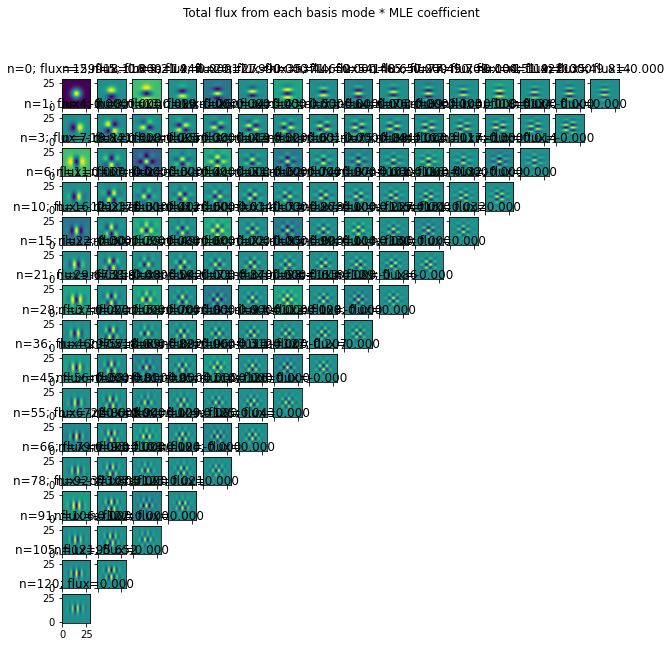

In [119]:
b = imap.get_basis()

X, Y = utils.build_map_grid(nx,ny)

size  = (10,10)
fig, axes = plt.subplots(nrows=b.Nmax+1, ncols=b.Nmax+1, sharex=True, sharey=True, figsize=size,
                        facecolor='w')

for n in range(b.N):
    Nx, Ny = b.n_to_NxNy(n)
    ax = axes[Nx, Ny]
    coeff = imap.fitter.mle_coefficients[n]
    func, args = b._get_basis_func(n)
    
    im = 1 * func(X, Y, *args)
    s = np.sum(im)
    ax.imshow(im, origin='lower')
    ax.set_title(f'n={n}; flux={s:.2f}')
    
for Nx in range(b.Nmax, 0, -1):
    for Ny in range(b.Nmax, 0, -1):
        if Nx+Ny > b.Nmax:
            axes[Nx,Ny].axis('off')
            
plt.suptitle('Total flux from each basis mode')
    
plt.show()
    
fig, axes = plt.subplots(nrows=b.Nmax+1, ncols=b.Nmax+1, sharex=True, sharey=True, figsize=size,
                        facecolor='w')
for n in range(b.N):
    Nx, Ny = b.n_to_NxNy(n)
    ax = axes[Nx, Ny]
    coeff = imap.fitter.mle_coefficients[n]
    func, args = b._get_basis_func(n)
    
    im = coeff * func(X, Y, *args)
    s = np.sum(im)
    ax.imshow(im, origin='lower')
    ax.set_title(f'n={n}; flux={s:.3f}')

for Nx in range(b.Nmax, 0, -1):
    for Ny in range(b.Nmax, 0, -1):
        if Nx+Ny > b.Nmax:
            axes[Nx,Ny].axis('off')
            
plt.suptitle('Total flux from each basis mode * MLE coefficient')

    
plt.show()

## Iterate fit

In [7]:
def compute_shapelet_flux(imap):
    
    basis = imap.get_basis()
    beta = basis.beta
    
    norm = np.sqrt(np.pi) * beta
    
    flux = 0
    
    for nx in range(0, basis.Nmax+2, 2):
        for ny in range(0, basis.Nmax+2, 2):
            if nx+ny > nmax:
                continue
                
            print(f'nx,ny = {nx}, {ny}')
            factor = 2**((2-nx-ny)/2)
            binom1 = np.sqrt(scipy.special.binom(nx, nx/2))
            binom2 = np.sqrt(scipy.special.binom(ny, ny/2))
            
            indx = basis.NxNy_to_n(nx, ny)
            print(f'indx={indx}')
            coeff = imap.fitter.mle_coefficients[indx]
            
            print(norm, factor, binom1, binom2, coeff)
            
            flux += (factor * binom1 * binom2 * coeff)
                
    return norm * flux
    
def compute_shapelet_rms(imap, datacube):
    
#     flux = compute_shapelet_flux(imap)
    image = datacube.stack()
    flux = np.sum(image)
    
    basis = imap.get_basis()
    beta = basis.beta
    
    norm = np.sqrt(np.pi) * beta**3 * (1/flux)
    print(f'norm = {norm:.4f}')
    
    rms = 0
    
    for nx in range(0, basis.Nmax+2, 2):
        for ny in range(0, basis.Nmax+2, 2):
            if nx+ny > nmax:
                continue
                
            print(f'nx,ny = {nx}, {ny}')
            factor = 2**((4-nx-nx)/2) * (1+nx+ny)
            binom1 = np.sqrt(scipy.special.binom(nx, nx/2))
            binom2 = np.sqrt(scipy.special.binom(ny, ny/2))
            
            indx = basis.NxNy_to_n(nx, ny)
            coeff = imap.fitter.mle_coefficients[indx]
            
            print(factor, binom1, binom2, coeff)
            
            rms += (factor * binom1 * binom2 * coeff)
    
    return norm * rms

In [8]:
compute_shapelet_flux(imap)

nx,ny = 0, 0
indx=0
9.708129562778495 2.0 1.0 1.0 3719.969851989831
nx,ny = 0, 2
indx=5
9.708129562778495 1.0 1.0 1.4142135623730951 -8171.265156481581
nx,ny = 2, 0
indx=3
9.708129562778495 1.0 1.4142135623730951 1.0 -10025.202611032986


-177598.11266491917

In [9]:
compute_shapelet_rms(imap, datacube)

norm = 0.0030
nx,ny = 0, 0
4.0 1.0 1.0 3719.969851989831
nx,ny = 0, 2
12.0 1.0 1.4142135623730951 -8171.265156481581
nx,ny = 2, 0
3.0 1.4142135623730951 1.0 -10025.202611032986


-498.4603129248214

In [10]:
vars(imap.fitter).keys()

dict_keys(['basis_type', 'nx', 'ny', 'grid', 'basis', 'Nbasis', 'mle_coefficients', 'design_mat', 'pseudo_inv', 'marginalize_det', 'marginalize_det_log', 'mle_im'])

In [11]:
imap.fitter.mle_coefficients

array([ 3.71996985e+03,  3.25013593e+00,  2.13130856e+00, -1.00252026e+04,
        3.55121710e+03, -8.17126516e+03])

In [12]:
imap.get_basis().ngrid

array([[ 0.,  2.,  5.],
       [ 1.,  4., -1.],
       [ 3., -1., -1.]])

In [13]:
imap.fitter.mle_coefficients

array([ 3.71996985e+03,  3.25013593e+00,  2.13130856e+00, -1.00252026e+04,
        3.55121710e+03, -8.17126516e+03])

In [14]:
mle_coeff = imap.fitter.mle_coefficients

array = np.zeros((nmax+1,nmax+1))
for i in range(nmax+1):
    for j in range(nmax+1):
        if i+j > nmax:
            continue
        indx = imap.get_basis().NxNy_to_n(i,j)
        array[i,j] = mle_coeff[indx]
        
print(array)

[[ 3.71996985e+03  2.13130856e+00 -8.17126516e+03]
 [ 3.25013593e+00  3.55121710e+03  0.00000000e+00]
 [-1.00252026e+04  0.00000000e+00  0.00000000e+00]]
